In [1]:
import pandas as pd
import numpy as np
import time
import re
import warnings
import math
from scipy.sparse import hstack
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_variants = pd.read_csv('training_variants.csv')
print('Number of observations in trainig variants is',train_variants.shape[0])
print('Number of features in training variants is',train_variants.shape[1])
print(train_variants.head())

Number of observations in trainig variants is 3321
Number of features in training variants is 4
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [3]:
train_text = pd.read_csv('training_text.csv',
                         sep='\|\|',engine='python',names=['ID','TEXT'],skiprows=1)
print('Number of observations in training text is',train_text.shape[0])
print('Number of features in training text is', train_text.shape[1])
print(train_text.head())

Number of observations in training text is 3321
Number of features in training text is 2
   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [4]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                pass
                string += word + " "
        
        train_text[column][index] = string      

In [5]:
# Text processing stage.
start_time = time.perf_counter()
for index, row in train_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id:", index)
print('Time taken for preprocessing the text:', time.perf_counter() - start_time, "seconds")

There is no text description for id: 1109
There is no text description for id: 1277
There is no text description for id: 1407
There is no text description for id: 1639
There is no text description for id: 2755
Time taken for preprocessing the text: 39.1133402000014 seconds


In [6]:
result = pd.merge(train_variants, train_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
print('Number of observations on result  is',result.shape[0])
print('Number of features on result is', result.shape[1])

Number of observations on result  is 3321
Number of features on result is 5


In [9]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +'  '+result['Variation']

In [11]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [12]:
print(result.columns)


Index(['ID', 'Gene', 'Variation', 'Class', 'TEXT'], dtype='object')


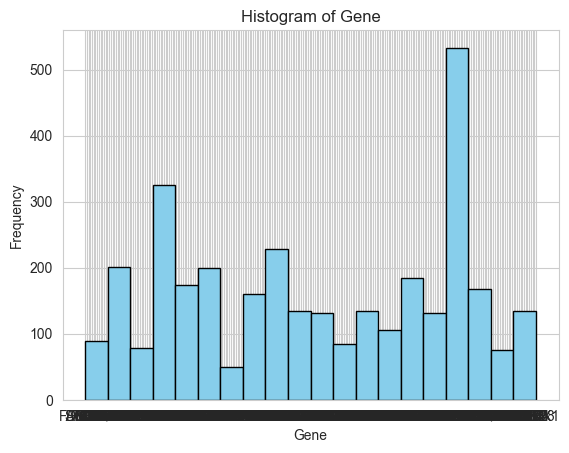

In [13]:
plt.hist(result['Gene'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Gene')
plt.xlabel('Gene')
plt.ylabel('Frequency')
plt.show()

# Train,Test and Cross-Validation split

In [14]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s', '_')
result.Variation =  result.Variation.str.replace('\s', '_')
X_train, test_df, y_train, y_test =  train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [15]:
print('Number of observations in train data:', train_df.shape[0])
print('Number of observations in test data:', test_df.shape[0])
print('Number of observation in cross validation data:', cv_df.shape[0])

Number of observations in train data: 2124
Number of observations in test data: 665
Number of observation in cross validation data: 532


# Distribution of y_i's in all the data sets

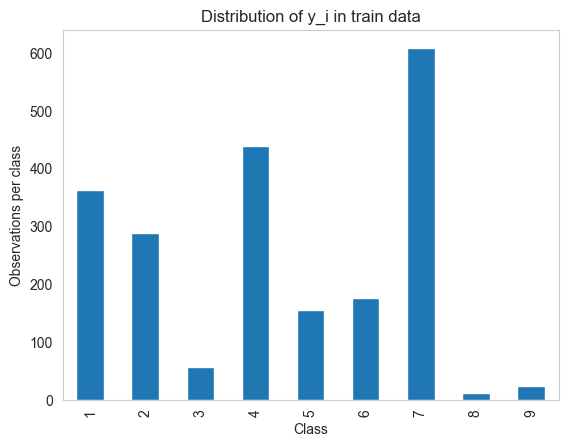

Number of observations in class: 7 : 609 ( 28.672 %)
Number of observations in class: 4 : 439 ( 20.669 %)
Number of observations in class: 1 : 363 ( 17.09 %)
Number of observations in class: 2 : 289 ( 13.606 %)
Number of observations in class: 6 : 176 ( 8.286 %)
Number of observations in class: 5 : 155 ( 7.298 %)
Number of observations in class: 3 : 57 ( 2.684 %)
Number of observations in class: 9 : 24 ( 1.13 %)
Number of observations in class: 8 : 12 ( 0.565 %)
----------------------------------------------------------------------------------------------------


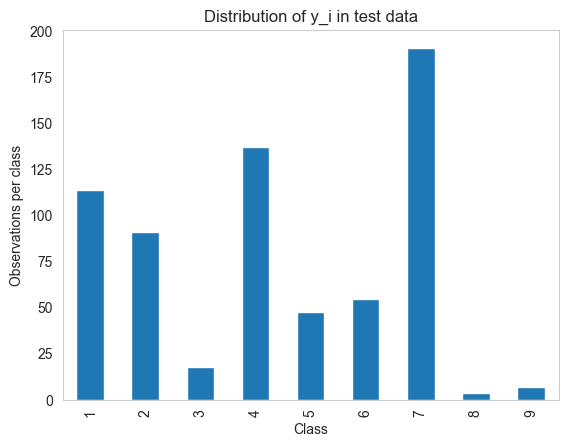

Number of observations in class: 7 : 191 ( 28.722 %)
Number of observations in class: 4 : 137 ( 20.602 %)
Number of observations in class: 1 : 114 ( 17.143 %)
Number of observations in class: 2 : 91 ( 13.684 %)
Number of observations in class: 6 : 55 ( 8.271 %)
Number of observations in class: 5 : 48 ( 7.218 %)
Number of observations in class: 3 : 18 ( 2.707 %)
Number of observations in class: 9 : 7 ( 1.053 %)
Number of observations in class: 8 : 4 ( 0.602 %)
----------------------------------------------------------------------------------------------------


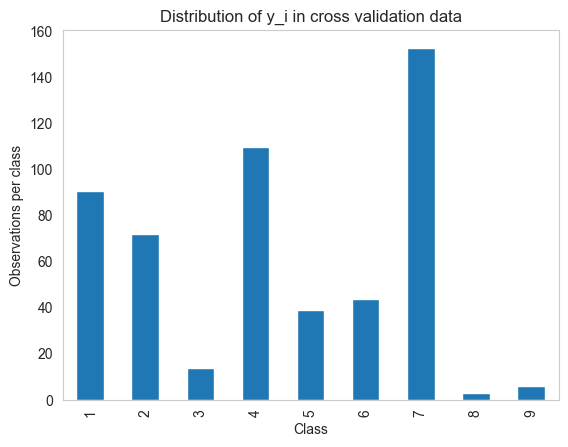

Number of observations in class: 7 : 153 ( 28.759 %)
Number of observations in class: 4 : 110 ( 20.677 %)
Number of observations in class: 1 : 91 ( 17.105 %)
Number of observations in class: 2 : 72 ( 13.534 %)
Number of observations in class: 6 : 44 ( 8.271 %)
Number of observations in class: 5 : 39 ( 7.331 %)
Number of observations in class: 3 : 14 ( 2.632 %)
Number of observations in class: 9 : 6 ( 1.128 %)
Number of observations in class: 8 : 3 ( 0.564 %)


In [16]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per class')
plt.title('Distribution of y_i in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of observations in class:',i+1,':',train_class_distribution.values[i],'(',
         np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

print('-'*100)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per class')
plt.title('Distribution of y_i in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of observations in class:',i+1,':',test_class_distribution.values[i],'(',
         np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
    
print('-'*100)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per class')
plt.title('Distribution of y_i in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of observations in class:',i+1,':',cv_class_distribution.values[i],'(',
         np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

# Prediction using a random model¶

In [17]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    B = (C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

Log loss on cross validation data using random model 2.425419983374866
Log loss on test data using random model 2.389561668761752
-------------------- Confusion matrix --------------------


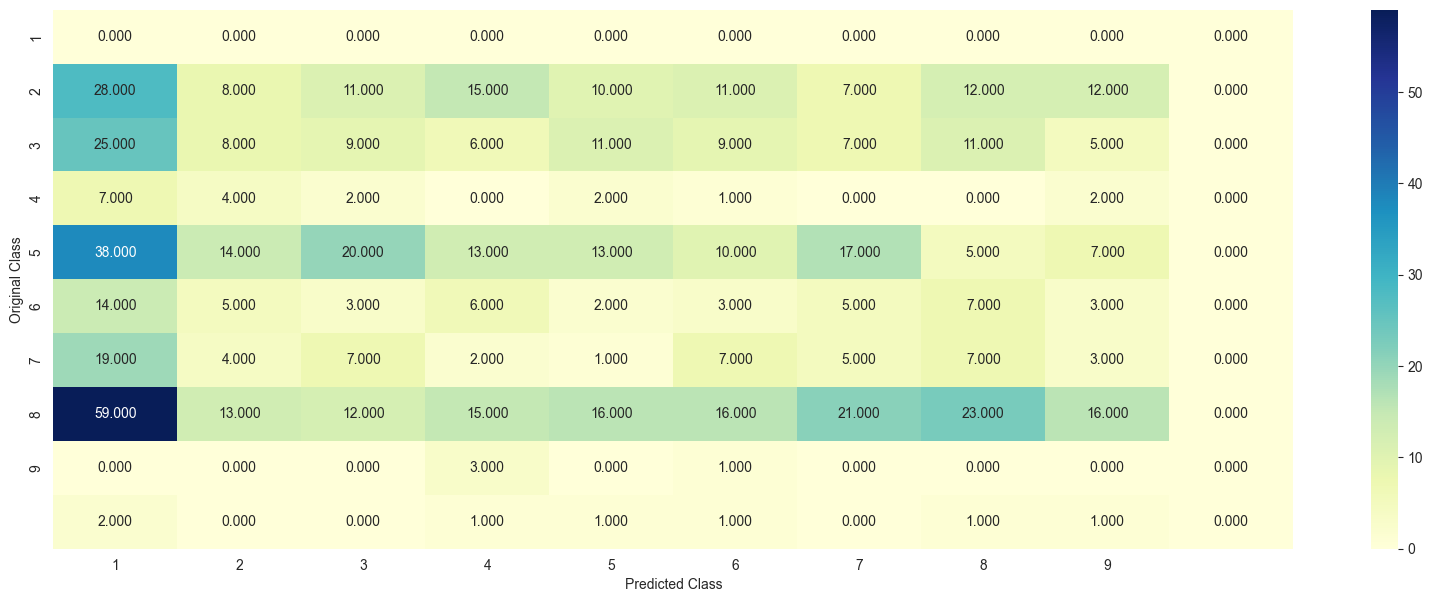

-------------------- Precision matrix (Columm Sum=1) --------------------


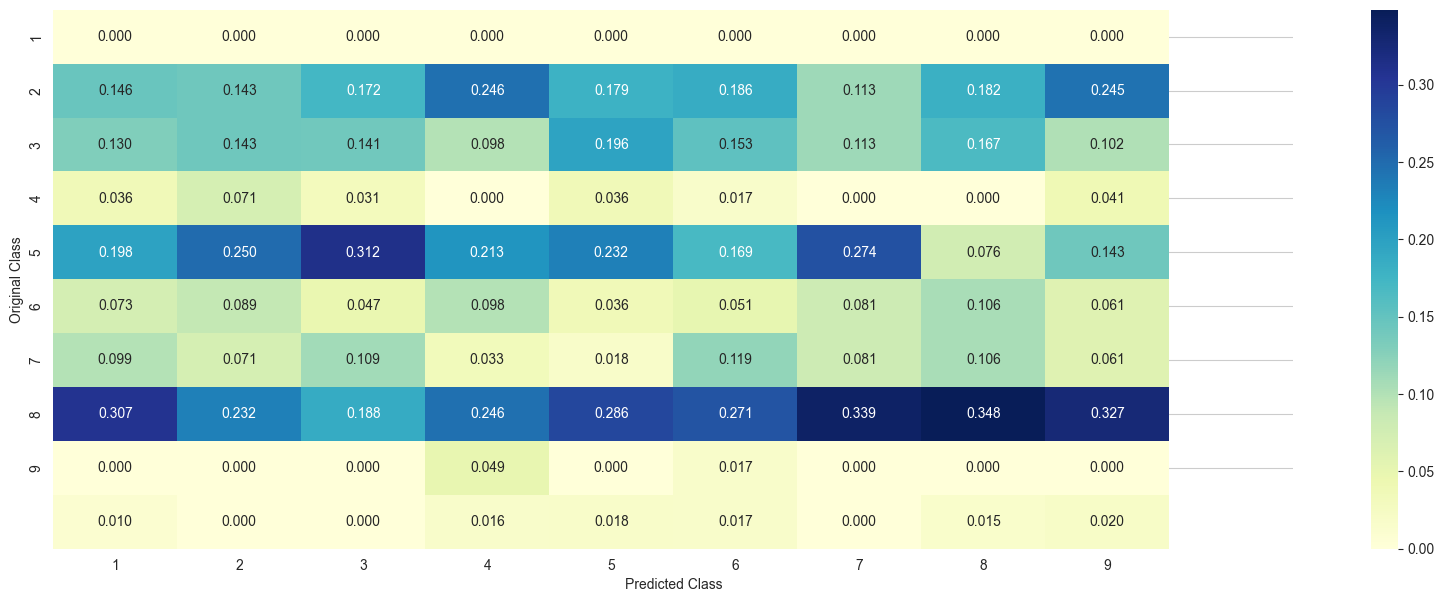

-------------------- Recall matrix (Row sum=1) --------------------


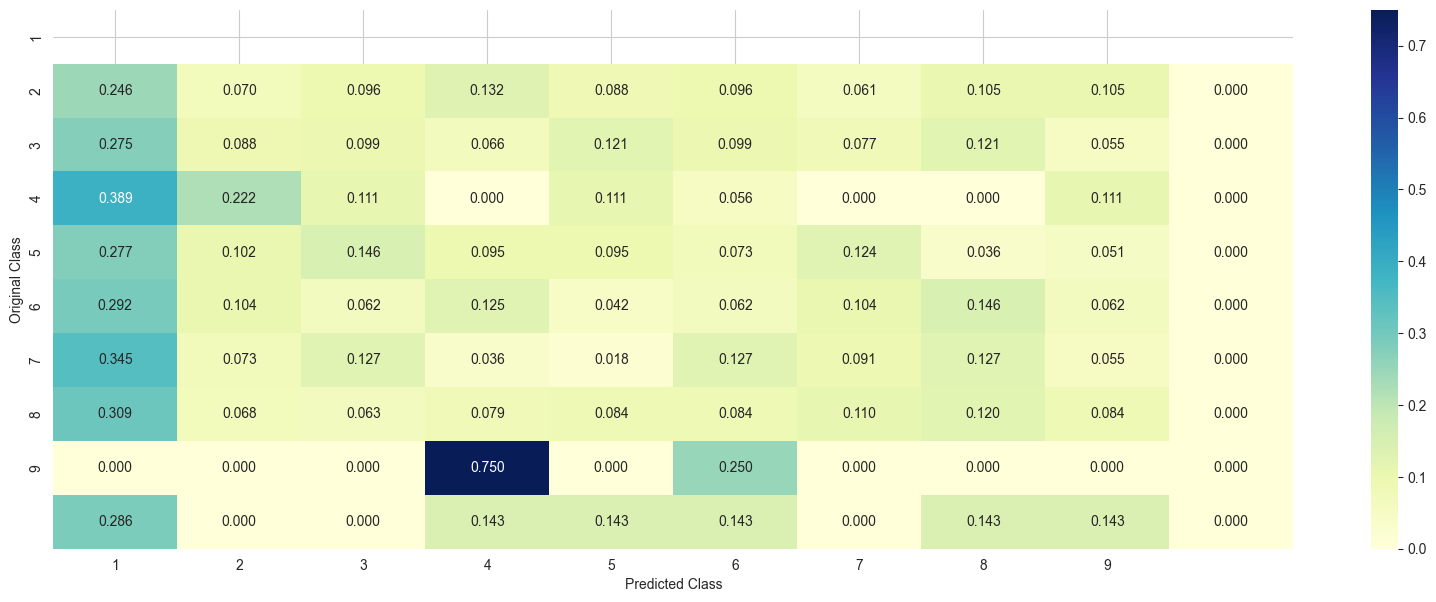

In [18]:
len_test_data = test_df.shape[0]
len_cv_data = cv_df.shape[0]

#create an output array that has exactly the same size as cv data
cv_predicted_y = np.zeros((len_cv_data, 9))
for i in range(len_cv_data):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0]) 
print('Log loss on cross validation data using random model', log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((len_test_data,9))
for i in range(len_cv_data):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0]) 
print('Log loss on test data using random model', log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Univariate Analysis

In [19]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec =[]
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0]+alpha*10)/(denominator+90*alpha))
        gv_dict[i] = vec
    return  gv_dict

#get gene variation faeture
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha,feature,df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if  row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    
    return gv_fea
    

# Univariate analysis on gene feature

In [20]:
unique_genes = train_df['Gene'].value_counts()
unique_genes_percent = train_df['Gene'].value_counts(normalize=True)
print('Number of unique genes: ',unique_genes.shape[0])
#the top genes that occured most
print(unique_genes.head(10))
print(unique_genes_percent.head(10))

Number of unique genes:  238
Gene
BRCA1     170
TP53      105
EGFR       90
BRCA2      85
PTEN       81
ERBB2      53
KIT        51
BRAF       50
ALK        49
CDKN2A     40
Name: count, dtype: int64
Gene
BRCA1     0.080038
TP53      0.049435
EGFR      0.042373
BRCA2     0.040019
PTEN      0.038136
ERBB2     0.024953
KIT       0.024011
BRAF      0.023540
ALK       0.023070
CDKN2A    0.018832
Name: proportion, dtype: float64


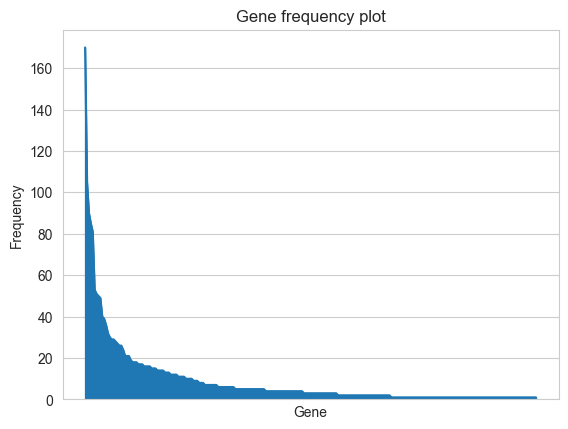

In [21]:
#plt.figure()
ax = train_df['Gene'].value_counts().plot(kind='area')
ax.get_xaxis().set_ticks([])
ax.set_title('Gene frequency plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

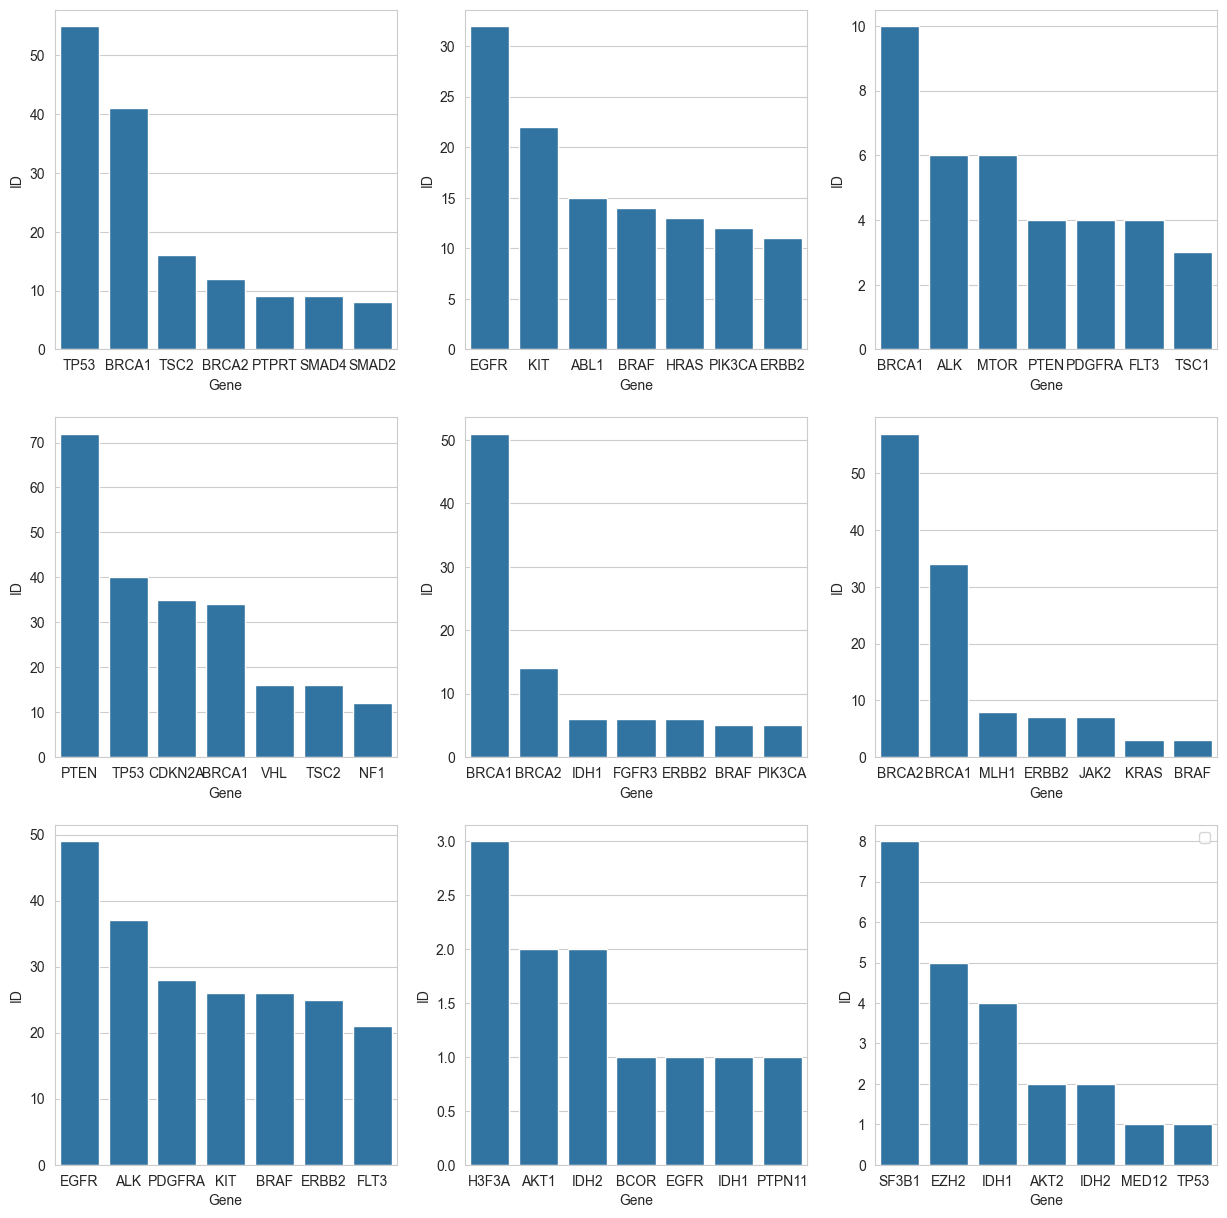

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_df[train_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        plt.legend()
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

><b>Some points we can conclude from these graphs:</b> BRCA1 is highly dominating in Class 5, SF3B1 is highly dominating in Class 9, BRCA1 and BRCA2 are dominating in Class 6

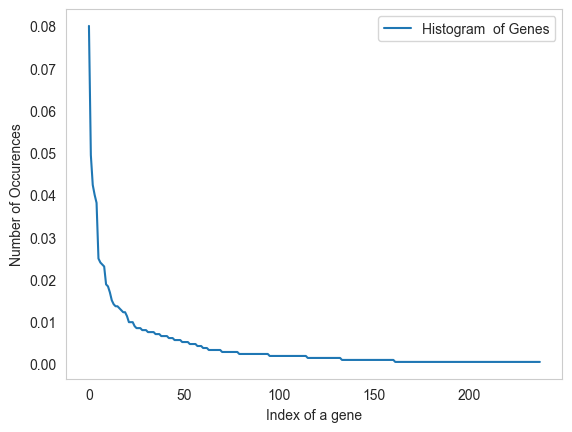

In [23]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label='Histogram  of Genes')
plt.xlabel('Index of a gene')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show()

# Featurize this gene faeture

In [24]:
alpha = 1
#train_gene_feature
train_gene_feature_rc = np.array(get_gv_feature(alpha,'Gene',train_df))
#test gene feature
test_gene_feature_rc = np.array(get_gv_feature(alpha, 'Gene', test_df))
#cv gene feature
cv_gene_feature_rc = np.array(get_gv_feature(alpha, 'Gene', cv_df))

In [25]:
train_gene_feature_rc =  (train_gene_feature_rc.T/train_gene_feature_rc.sum(axis=1)).T
test_gene_feature_rc =  (test_gene_feature_rc.T/test_gene_feature_rc.sum(axis=1)).T
cv_gene_feature_rc =  (cv_gene_feature_rc.T/cv_gene_feature_rc.sum(axis=1)).T

In [26]:
print('Number of response encoded features in train data = '+str(train_gene_feature_rc.shape[0]))
print('Number of response encoded features in test data = '+str(test_gene_feature_rc.shape[0]))
print('Number of response encoded features in cv data = '+str(cv_gene_feature_rc.shape[0]))

Number of response encoded features in train data = 2124
Number of response encoded features in test data = 665
Number of response encoded features in cv data = 532


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer = CountVectorizer()
#one hot encode the gene feature
train_gene_feature_ohc  = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_ohc  = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_ohc  = gene_vectorizer.transform(cv_df['Gene'])

In [28]:
print('Size of one hot encoded in train data is', (train_gene_feature_ohc.shape))
print('Size of one hot encoded in test data is', (test_gene_feature_ohc.shape))
print('Size of one hot encoded in cv data is', (cv_gene_feature_ohc.shape))

Size of one hot encoded in train data is (2124, 238)
Size of one hot encoded in test data is (665, 238)
Size of one hot encoded in cv data is (532, 238)


For values of alpha = 1e-05 The log loss is 1.204048583690137
For values of alpha = 0.0001 The log loss is 1.1750224738989925
For values of alpha = 0.001 The log loss is 1.2002748823205764
For values of alpha = 0.01 The log loss is 1.3043365371759572
For values of alpha = 0.1 The log loss is 1.4203736047543134
For values of alpha = 1 The log loss is 1.4583984949053588


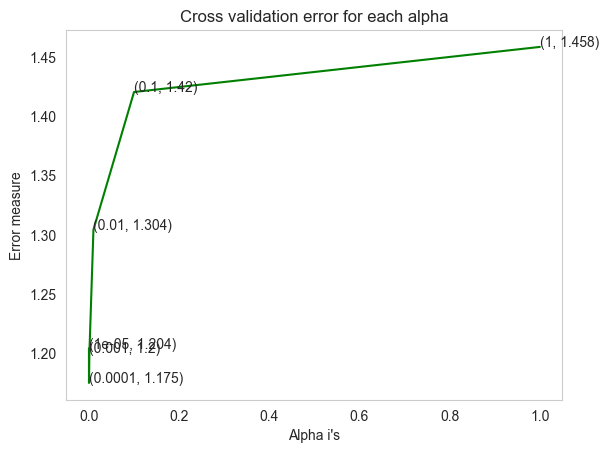

For values of best alpha =  0.0001 the train log loss is  1.0089814153689465
For values of best alpha =  0.0001 the cross validation log loss is  1.1750224738989925
For values of best alpha =  0.0001 the test log loss is  1.1613947306858647


In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_ohc, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_feature_ohc, y_train)
    y_pred = sig_clf.predict_proba(cv_gene_feature_ohc)
    cv_log_loss.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of alpha =', i, 'The log loss is', log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_loss, c='g')
for i, txt in enumerate(np.round(cv_log_loss, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_loss[i]))
plt.grid()
plt.title('Cross validation error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel('Error measure')
plt.show()

best_alpha = np.argmin(cv_log_loss)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_ohc, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_feature_ohc, y_train)

y_pred = sig_clf.predict_proba(train_gene_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha],
      'the train log loss is ', log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(cv_gene_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha],
      'the cross validation log loss is ', log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(test_gene_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha],
      'the test log loss is ', log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))


# Correlation between the genes in the Train,test and cv sets

In [30]:
test_coverage = test_df[test_df['Gene'].isin(list(train_df['Gene']))].shape[0]

cv_coverage = cv_df[cv_df['Gene'].isin(list(train_df['Gene']))].shape[0]
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0] ,":" ,(cv_coverage/cv_df.shape[0])*100)

In test data 646 out of 665 : 97.14285714285714
In cross validation data 516 out of  532 : 96.99248120300751


# Univariate analysis on Variation feature

In [31]:
unique_variation = train_df['Variation'].value_counts()
unique_variation_percent = train_df['Variation'].value_counts(normalize=True)
print('Number of unique variations: ',unique_variation.shape[0])
print(unique_variation.head(10))
print(unique_variation_percent.head(10))

Number of unique variations:  1928
Variation
Truncating Mutations    63
Amplification           49
Deletion                47
Fusions                 19
Overexpression           3
G13D                     2
G13V                     2
S308A                    2
Q61R                     2
A146T                    2
Name: count, dtype: int64
Variation
Truncating Mutations    0.029661
Amplification           0.023070
Deletion                0.022128
Fusions                 0.008945
Overexpression          0.001412
G13D                    0.000942
G13V                    0.000942
S308A                   0.000942
Q61R                    0.000942
A146T                   0.000942
Name: proportion, dtype: float64


In [32]:
print('There are',unique_variation.shape[0],'in the train data')

There are 1928 in the train data


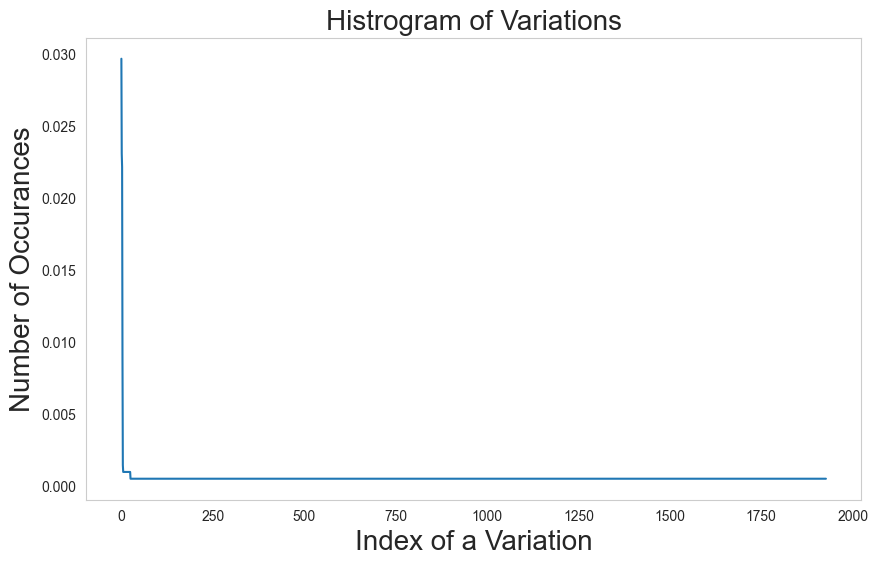

In [33]:
s = sum(unique_variation.values)
h = unique_variation.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

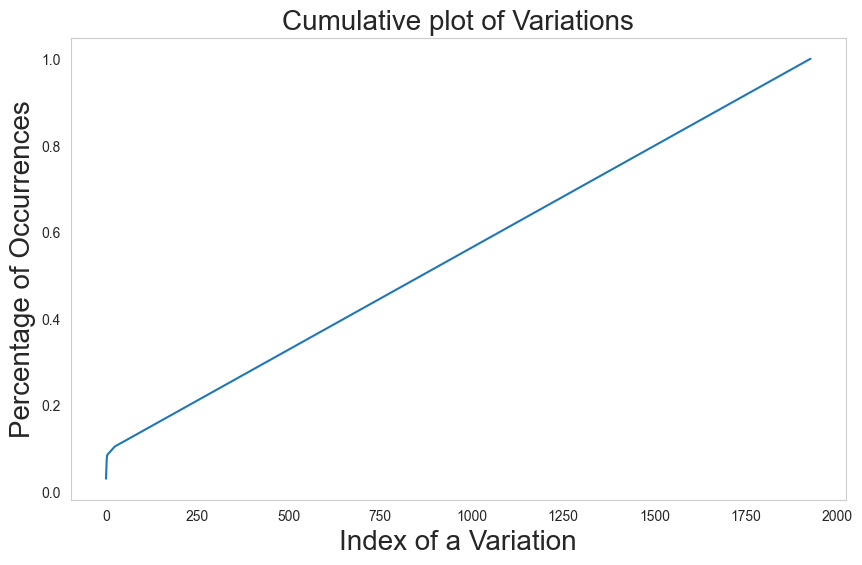

In [34]:
s = sum(unique_variation.values)
h = unique_variation.values/s
c = np.cumsum(h)
plt.figure(figsize = (10, 6))
plt.plot(c)
plt.title("Cumulative plot of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Percentage of Occurrences', fontsize = 20)
plt.grid()
plt.show()

In [35]:
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [36]:
print('Shape of train variation feature responsecoding is',train_variation_feature_responseCoding.shape)
print('Shape of test variation feature responsecoding is',test_variation_feature_responseCoding.shape)
print('Shape of cv variation feature responsecoding is',cv_variation_feature_responseCoding.shape)

Shape of train variation feature responsecoding is (2124, 9)
Shape of test variation feature responsecoding is (665, 9)
Shape of cv variation feature responsecoding is (532, 9)


In [37]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_ohc = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_ohc = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_ohc = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 The log loss is: 1.7292767720301088
For values of alpha =  0.0001 The log loss is: 1.720324803746996
For values of alpha =  0.001 The log loss is: 1.7232728637209986
For values of alpha =  0.01 The log loss is: 1.7336769789200137
For values of alpha =  0.1 The log loss is: 1.7532779074392746
For values of alpha =  1 The log loss is: 1.754104550717702


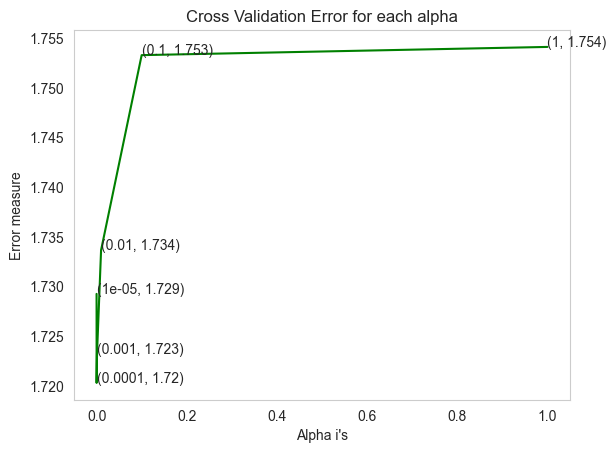

For values of best alpha =  0.0001 The train log loss is: 0.7266226060795173
For values of best alpha =  0.0001 The cross validation log loss is: 1.720324803746996
For values of best alpha =  0.0001 The test log loss is: 1.684121749529529


In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_ohc, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_ohc, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_ohc)
    
    cv_log_loss.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_loss,c='g')
for i, txt in enumerate(np.round(cv_log_loss,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_loss[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_loss)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_ohc, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_ohc, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# Univariate analysis on text feature

In [39]:
def text_occurence_dict(text_class):
  dictt = defaultdict(int)
  for index, row in text_class.iterrows():
    for word in row['TEXT'].split():
      dictt[word] += 1
  return dictt

In [40]:
list_dict = []
for i  in range(1,10):
  text_class = train_df[train_df['Class']==i]
  list_dict.append(text_occurence_dict(text_class))
total_dict = text_occurence_dict(train_df)

In [41]:
def create_text_rc(df):
  alpha = 10
  text_feature_rc = np.zeros((df.shape[0], 9))
  for i in range(0,9):
    row_index = 0
    for index, rows in df.iterrows():
      sumprob = 0
      for word in row['TEXT'].split():
        sumprob += math.log(((list_dict[i].get(word,0))+alpha)/((total_dict.get(word,0))+(9*alpha)))
      text_feature_rc[row_index][i] = np.exp(sumprob/len(row['TEXT'].split()))
      row_index += 1
  return text_feature_rc

In [42]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Retrieve feature names from vocabulary_
train_text_features = text_vectorizer.vocabulary_.keys()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(train_text_features, train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

Total number of unique words in train data: 53247


In [43]:
train_text_feature_rc = create_text_rc(train_df)
cv_text_feature_rc = create_text_rc(cv_df)
test_text_feature_rc = create_text_rc(test_df)

In [44]:
#convert each row such that they sum to 1
train_text_feature_rc = (train_text_feature_rc.T/train_text_feature_rc.sum(axis=1)).T
cv_text_feature_rc =  (cv_text_feature_rc.T/cv_text_feature_rc.sum(axis=1)).T
test_text_feature_rc = (test_text_feature_rc.T/test_text_feature_rc.sum(axis=1)).T

In [45]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [46]:
sorted_text_feature_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_occurence = np.array(list(sorted_text_feature_dict.values()))
print(Counter(sorted_text_occurence))

Counter({3: 5051, 4: 3920, 5: 2875, 6: 2552, 8: 2133, 7: 2087, 10: 1810, 9: 1500, 12: 1198, 14: 1153, 11: 1153, 13: 922, 16: 864, 15: 852, 18: 660, 20: 621, 17: 619, 19: 492, 21: 490, 24: 487, 22: 443, 40: 440, 27: 427, 23: 409, 28: 356, 25: 348, 26: 345, 30: 344, 29: 327, 36: 303, 54: 287, 31: 283, 32: 280, 33: 259, 34: 237, 38: 236, 35: 235, 37: 212, 39: 201, 48: 199, 42: 195, 44: 176, 41: 176, 49: 169, 43: 169, 60: 157, 56: 155, 51: 155, 45: 154, 47: 153, 50: 152, 46: 149, 55: 148, 52: 141, 53: 139, 64: 131, 61: 125, 80: 120, 62: 118, 72: 114, 69: 110, 58: 108, 57: 107, 63: 104, 68: 101, 59: 99, 65: 98, 75: 94, 70: 93, 67: 91, 84: 86, 71: 86, 66: 84, 81: 83, 74: 82, 73: 75, 98: 74, 77: 73, 85: 72, 82: 71, 79: 71, 95: 70, 90: 68, 83: 67, 108: 66, 78: 64, 120: 63, 97: 63, 91: 63, 88: 63, 93: 62, 76: 62, 86: 61, 112: 57, 102: 57, 94: 57, 92: 57, 87: 56, 104: 55, 100: 55, 96: 54, 111: 53, 103: 53, 89: 53, 109: 51, 114: 50, 101: 49, 121: 46, 116: 46, 115: 46, 99: 46, 124: 45, 106: 43, 14

In [47]:
print('Size of response encoded text feature in train data:',train_text_feature_rc.shape)
print('Size of response encoded text feature in test data:',test_text_feature_rc.shape)
print('Size of response encoded text feature in cv data:',cv_text_feature_rc.shape)

Size of response encoded text feature in train data: (2124, 9)
Size of response encoded text feature in test data: (665, 9)
Size of response encoded text feature in cv data: (532, 9)


# TFIDF

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=3, max_features=100000)

train_text_tfidf = tfidf_vec.fit_transform(train_df['TEXT'])
train_text_tfidf = StandardScaler(with_mean=False).fit_transform(train_text_tfidf)

# Test data
test_text_tfidf = tfidf_vec.transform(test_df['TEXT'])
test_text_tfidf = StandardScaler(with_mean=False).fit_transform(test_text_tfidf)

# CV data
cv_text_tfidf = tfidf_vec.transform(cv_df['TEXT'])
cv_text_tfidf = StandardScaler(with_mean=False).fit_transform(cv_text_tfidf)


For values of 1e-05 CV log loss is 1.4006246054303484
For values of 0.0001 CV log loss is 1.408875462172156
For values of 0.001 CV log loss is 1.4016757128892487
For values of 0.01 CV log loss is 1.4040157008026488
For values of 0.1 CV log loss is 1.2666833504219797
For values of 1 CV log loss is 1.0903027964953884
For values of 10 CV log loss is 1.0765020317739746
For values of 15 CV log loss is 1.0858951362060232
For values of 20 CV log loss is 1.0941157863408302
For values of 40 CV log loss is 1.1303561981063497


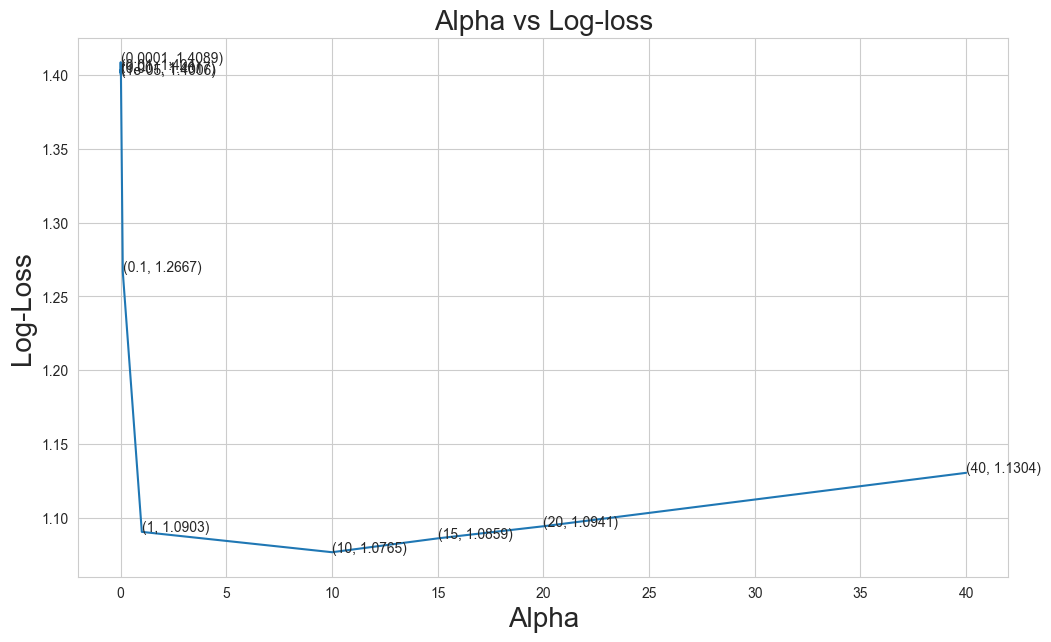

In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

alpha = [10 ** x for x in range(-5, 2)]
alpha.append(15)
alpha.append(20)
alpha.append(40)

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_tfidf, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_text_tfidf, y_train)
    y_pred = calib_clf.predict_proba(cv_text_tfidf)
    cv_log_loss.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of ' + str(i) + ' CV log loss is ' + str(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)))

plt.figure(figsize=(12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)

plt.title("Alpha vs Log-loss", fontsize=20)
plt.xlabel("Alpha", fontsize=20)
plt.ylabel("Log-Loss", fontsize=20)
plt.show()

In [51]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_tfidf, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_text_tfidf, y_train)

train_pred = calib_clf.predict_proba(train_text_tfidf)
print('For values of best alpha = ', best_alpha, "the train log loss =:", log_loss(y_train, train_pred, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_text_tfidf)
print('For values of best alpha = ', best_alpha, "the CV log loss =:", log_loss(y_cv, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_text_tfidf)
print('For values of best alpha = ', best_alpha, "the test log loss =:", log_loss(y_test, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.6381363304582608
For values of best alpha =  10 the CV log loss =: 1.0765020317739746
For values of best alpha =  10 the test log loss =: 1.051050137274527


In [52]:
from sklearn.feature_extraction.text import CountVectorizer

def get_intersect_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()  # Use get_feature_names_out() instead
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(df_text_features, df_text_fea_counts))
    return len(set(train_text_features) & set(df_text_features)), len(set(df_text_features))

len1, len2 = get_intersect_text(test_df)
print(np.round((len1 / len2) * 100, 3), '% of word occurrences of test data appeared in train data')
len1, len2 = get_intersect_text(cv_df)
print(np.round((len1 / len2) * 100, 3), '% of word occurrences of cv data appeared in train data')


96.919 % of word occurrences of test data appeared in train data
98.05 % of word occurrences of cv data appeared in train data


# Machine learning models

In [53]:
loss_table = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

In [54]:
train_gene_var_ohc = hstack((train_gene_feature_ohc,train_variation_feature_ohc))
test_gene_var_ohc = hstack((test_gene_feature_ohc,test_variation_feature_ohc))
cv_gene_var_ohc = hstack((cv_gene_feature_ohc,cv_variation_feature_ohc))

train_x = hstack((train_gene_var_ohc, train_text_tfidf))
train_x = train_x.tocsr()
train_y = np.array(list(train_df['Class']))

test_x = hstack((test_gene_var_ohc, test_text_tfidf))
test_x =  test_x.tocsr()
test_y = np.array(list(test_df['Class']))

cv_x = hstack((cv_gene_var_ohc, cv_text_tfidf))
cv_x = cv_x.tocsr()
cv_y = np.array(list(cv_df['Class']))

print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(train_x.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(cv_x.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(test_x.shape))

train_gene_var_rc = np.hstack((train_gene_feature_rc,train_variation_feature_responseCoding))
test_gene_var_rc = np.hstack((test_gene_feature_rc,test_variation_feature_responseCoding))
cv_gene_var_rc = np.hstack((cv_gene_feature_rc,cv_variation_feature_responseCoding))

train_x_rc = np.hstack((train_gene_var_rc, train_text_feature_rc))
test_x_rc = np.hstack((test_gene_var_rc, test_text_feature_rc))
cv_x_rc = np.hstack((cv_gene_var_rc, cv_text_feature_rc))

print('-'*50)
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(train_x_rc.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(cv_x_rc.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(test_x_rc.shape))

Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = (2124, 102199)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = (532, 102199)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = (665, 102199)
--------------------------------------------------
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = (2124, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = (532, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = (665, 27)


# Baseline models

# Naive Bayes

For alpha value of 1e-05 CV log loss = 1.2609375650519519
For alpha value of 0.0001 CV log loss = 1.2624891908128626
For alpha value of 0.001 CV log loss = 1.273599895669354
For alpha value of 0.01 CV log loss = 1.2790518469405983
For alpha value of 0.1 CV log loss = 1.2836459191621918
For alpha value of 1 CV log loss = 1.2916386250067058
For alpha value of 10 CV log loss = 1.3322670821292402
For alpha value of 100 CV log loss = 1.4143116738758237
For alpha value of 1000 CV log loss = 1.517680595132516
For alpha value of 10000 CV log loss = 1.521187096051949


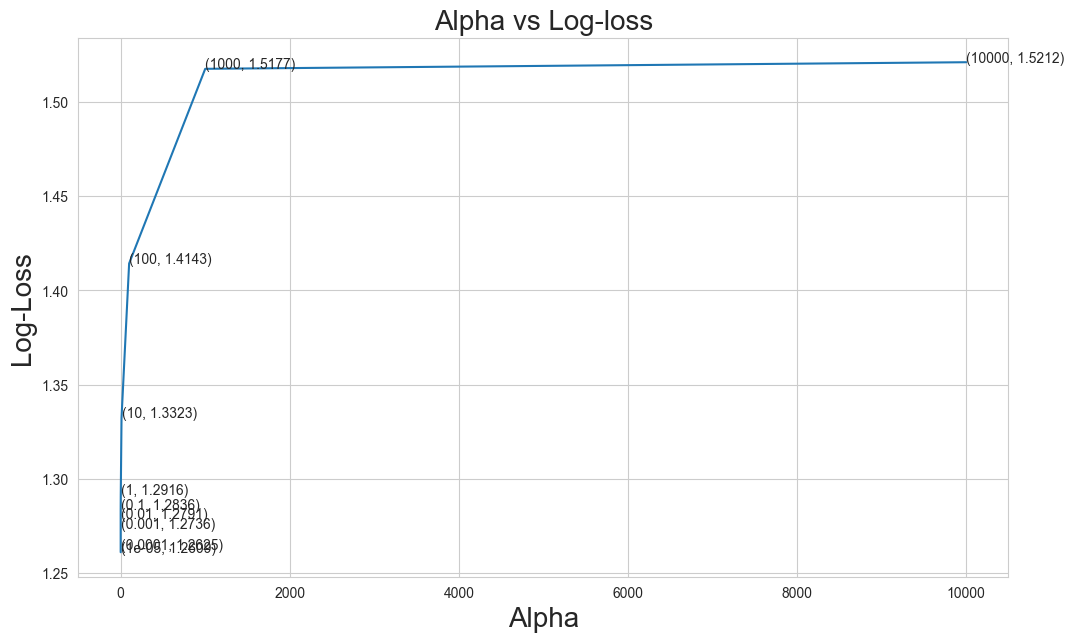

In [55]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_x, train_y)
    predicted_y = calib_clf.predict_proba(cv_x)
    cv_log_loss.append(log_loss(cv_y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [56]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x,train_y)
calib_clf_NB = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_NB.fit(train_x, train_y)

predict_train = calib_clf_NB.predict_proba(train_x)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_NB.predict_proba(cv_x)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_NB.predict_proba(test_x)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best alpha =  1e-05 the train log loss =: 0.9158009329358758
For values of best alpha =  1e-05 the CV log loss =: 1.2609375650519519
For values of best alpha =  1e-05 the test log loss =: 1.271836007328028


# Feature Importance

In [57]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_NB.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_NB.predict(test_x) - test_y)/test_y.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 38.16%
Percentage of mis-classified for Test points = 39.25%


In [58]:
import pandas as pd

loss_table = pd.DataFrame(columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])
print(type(loss_table))


<class 'pandas.core.frame.DataFrame'>


In [59]:
import pandas as pd

loss_table = pd.DataFrame(columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

# Create a new DataFrame with the data to append
new_data = pd.DataFrame([["Naive Bayes", 0.9157, 1.2169, 1.329, "36.84%", "42.86%", "Overfit"]], columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

# Concatenate the two DataFrames
loss_table = pd.concat([loss_table, new_data], ignore_index=True)

print(loss_table)


         Model  Train Log-loss  CV Log-loss  Test Log-loss Mis-Classified CV  \
0  Naive Bayes          0.9157       1.2169          1.329            36.84%   

  Mis-Classified Test  Remarks  
0              42.86%  Overfit  


# Naive Bayes Summary

In [60]:
loss_table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,Naive Bayes,0.9157,1.2169,1.329,36.84%,42.86%,Overfit


# KNearest Neighbors

For Neighbor value of 3 CV log loss = 1.6424552136099364
For Neighbor value of 5 CV log loss = 1.509471672379549
For Neighbor value of 8 CV log loss = 1.3890699451147557
For Neighbor value of 13 CV log loss = 1.3083032104501973
For Neighbor value of 23 CV log loss = 1.2468016926154208
For Neighbor value of 35 CV log loss = 1.2154654728235113
For Neighbor value of 51 CV log loss = 1.1991135708374216
For Neighbor value of 71 CV log loss = 1.1744759127698514
For Neighbor value of 95 CV log loss = 1.1812753663448017
For Neighbor value of 121 CV log loss = 1.1673234099009382
For Neighbor value of 151 CV log loss = 1.1649602390212765
For Neighbor value of 181 CV log loss = 1.1719472021771837
For Neighbor value of 221 CV log loss = 1.177293200729629


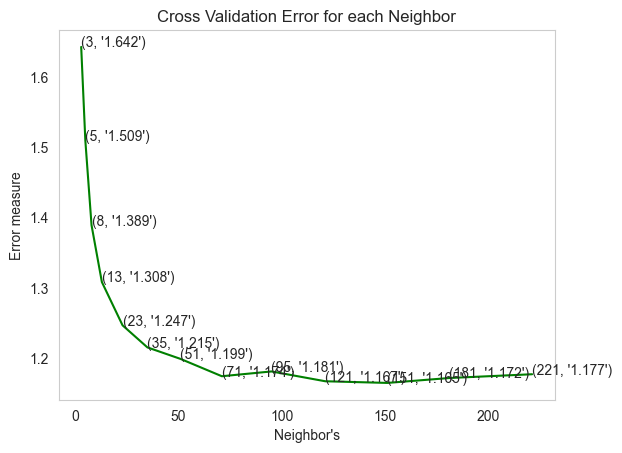

In [62]:
neighbors = [3, 5, 8, 13, 23, 35, 51, 71, 95, 121, 151, 181, 221]
cv_log_loss = []

for i in neighbors:
  clf = KNeighborsClassifier(n_neighbors = i,n_jobs = -1)
  clf.fit(train_x_rc,train_y)
  calib_clf_KNN =  CalibratedClassifierCV(clf,method='sigmoid')
  calib_clf_KNN.fit(train_x_rc,train_y)
  y_pred = calib_clf_KNN.predict_proba(cv_x_rc)
  cv_log_loss.append(log_loss(cv_y,y_pred,labels=clf.classes_))
  print("For Neighbor value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, y_pred,labels=clf.classes_)))

fig, ax = plt.subplots()
ax.plot(neighbors,cv_log_loss,c='g')
for i,txt in enumerate(np.round(cv_log_loss,3)):
  ax.annotate((neighbors[i],str(txt)),(neighbors[i],cv_log_loss[i]))
plt.grid()
plt.title("Cross Validation Error for each Neighbor")
plt.xlabel("Neighbor's")
plt.ylabel("Error measure")
plt.show()

In [63]:
best_neighbors = neighbors[np.argmin(cv_log_loss)]
clf = KNeighborsClassifier(n_neighbors = best_neighbors, n_jobs = -1)
clf.fit(train_x_rc, train_y)
calib_clf_KNN = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_KNN.fit(train_x_rc, train_y)

predict_train = calib_clf_KNN.predict_proba(train_x_rc)
print('For values of best neighbors = ', best_neighbors, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_KNN.predict_proba(cv_x_rc)
print('For values of best neighbors = ', best_neighbors, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_KNN.predict_proba(test_x_rc)
print('For values of best neighbors = ', best_neighbors, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best neighbors =  151 the train log loss =: 0.9932065107425311
For values of best neighbors =  151 the CV log loss =: 1.1649602390212765
For values of best neighbors =  151 the test log loss =: 1.1387052989063817


# Feature Importance

In [64]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_KNN.predict(cv_x_rc) - cv_y)/cv_x_rc.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_KNN.predict(test_x_rc) - test_y)/test_x_rc.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 43.23%
Percentage of mis-classified for Test points = 42.41%


In [65]:
import pandas as pd

# If loss_table does not exist or is not initialized yet
loss_table = pd.DataFrame(columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

# Append the new data using concatenation
new_data = pd.DataFrame([["KNearest Neighbors", 0.9836, 1.1685, 1.184, "41.35%", "43.76%", "Goodfit"]], columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])
loss_table = pd.concat([loss_table, new_data], ignore_index=True)

print(loss_table)

                Model  Train Log-loss  CV Log-loss  Test Log-loss  \
0  KNearest Neighbors          0.9836       1.1685          1.184   

  Mis-Classified CV Mis-Classified Test  Remarks  
0            41.35%              43.76%  Goodfit  


# KNearest Neighbors Summary

In [66]:
loss_table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,KNearest Neighbors,0.9836,1.1685,1.184,41.35%,43.76%,Goodfit


# Logistic Regression

For alpha value of 1e-05 CV log loss = 1.4148350770676972
For alpha value of 0.0001 CV log loss = 1.4102392390946241
For alpha value of 0.001 CV log loss = 1.4310550978076597
For alpha value of 0.01 CV log loss = 1.4358195798377726
For alpha value of 0.1 CV log loss = 1.2448357712504365
For alpha value of 1 CV log loss = 1.0866464464256127
For alpha value of 10 CV log loss = 1.0844066589019703
For alpha value of 100 CV log loss = 1.2367495585896773
For alpha value of 1000 CV log loss = 1.4630709887655455
For alpha value of 10000 CV log loss = 1.5437969140825687


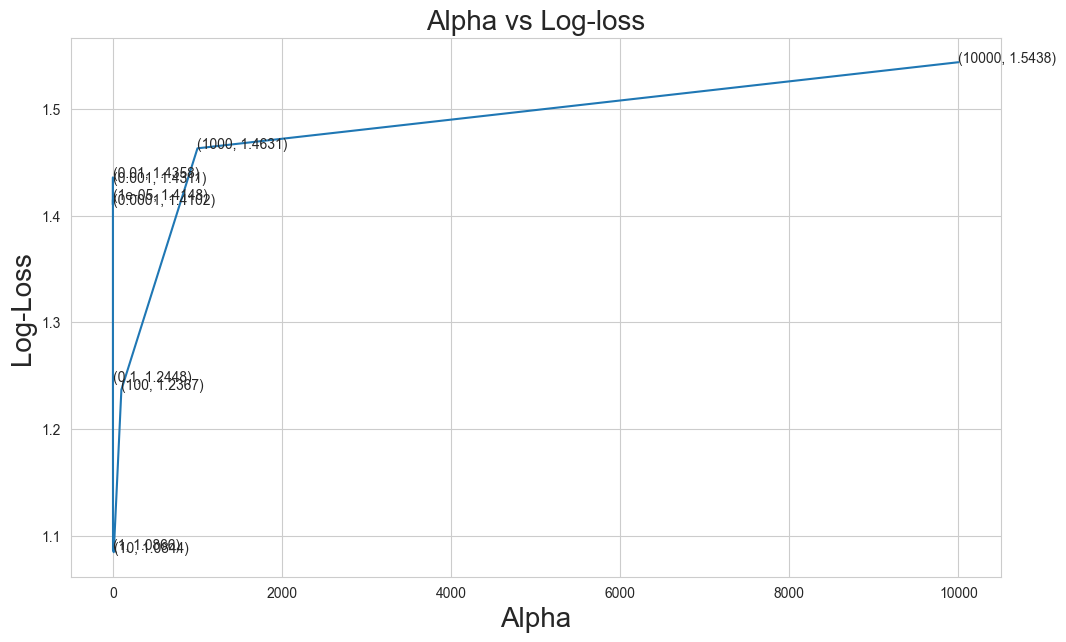

In [68]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss="log_loss", alpha=i, class_weight="balanced")
    clf.fit(train_x, train_y)
    calib_clf_LR = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf_LR.fit(train_x, train_y)
    y_pred = calib_clf_LR.predict_proba(cv_x)
    cv_log_loss.append(log_loss(cv_y, y_pred, labels=clf.classes_))
    print("For alpha value of " + str(i) + " CV log loss = " + str(log_loss(cv_y, y_pred, labels=clf.classes_)))

plt.figure(figsize=(12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)

plt.title("Alpha vs Log-loss", fontsize=20)
plt.xlabel("Alpha", fontsize=20)
plt.ylabel("Log-Loss", fontsize=20)
plt.show()

In [69]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss="log_loss", alpha=best_alpha, class_weight="balanced")
clf.fit(train_x, train_y)
calib_clf_LR = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf_LR.fit(train_x, train_y)

predict_train = calib_clf_LR.predict_proba(train_x)
print('For values of best alpha =', best_alpha, "the train log loss =", log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_LR.predict_proba(cv_x)
print('For values of best alpha =', best_alpha, "the CV log loss =", log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_LR.predict_proba(test_x)
print('For values of best alpha =', best_alpha, "the test log loss =", log_loss(test_y, predict_test, labels=clf.classes_))

For values of best alpha = 10 the train log loss = 0.649023364929052
For values of best alpha = 10 the CV log loss = 1.0852393819395696
For values of best alpha = 10 the test log loss = 1.055905304964252


# Feature Importance

In [70]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_LR.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_LR.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 39.29%
Percentage of mis-classified for Test points = 35.49%


In [71]:
import pandas as pd
loss_table = pd.DataFrame(columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])
new_data = pd.DataFrame([["Logistic Regression", 0.563, 1.133, 1.161, "36.09%", "39.4%", "Overfit"]], columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])
loss_table = pd.concat([loss_table, new_data], ignore_index=True)
print(loss_table)

                 Model  Train Log-loss  CV Log-loss  Test Log-loss  \
0  Logistic Regression           0.563        1.133          1.161   

  Mis-Classified CV Mis-Classified Test  Remarks  
0            36.09%               39.4%  Overfit  


# Logistic Regression Summary

In [72]:
loss_table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,Logistic Regression,0.563,1.133,1.161,36.09%,39.4%,Overfit


-------------------- Confusion matrix --------------------


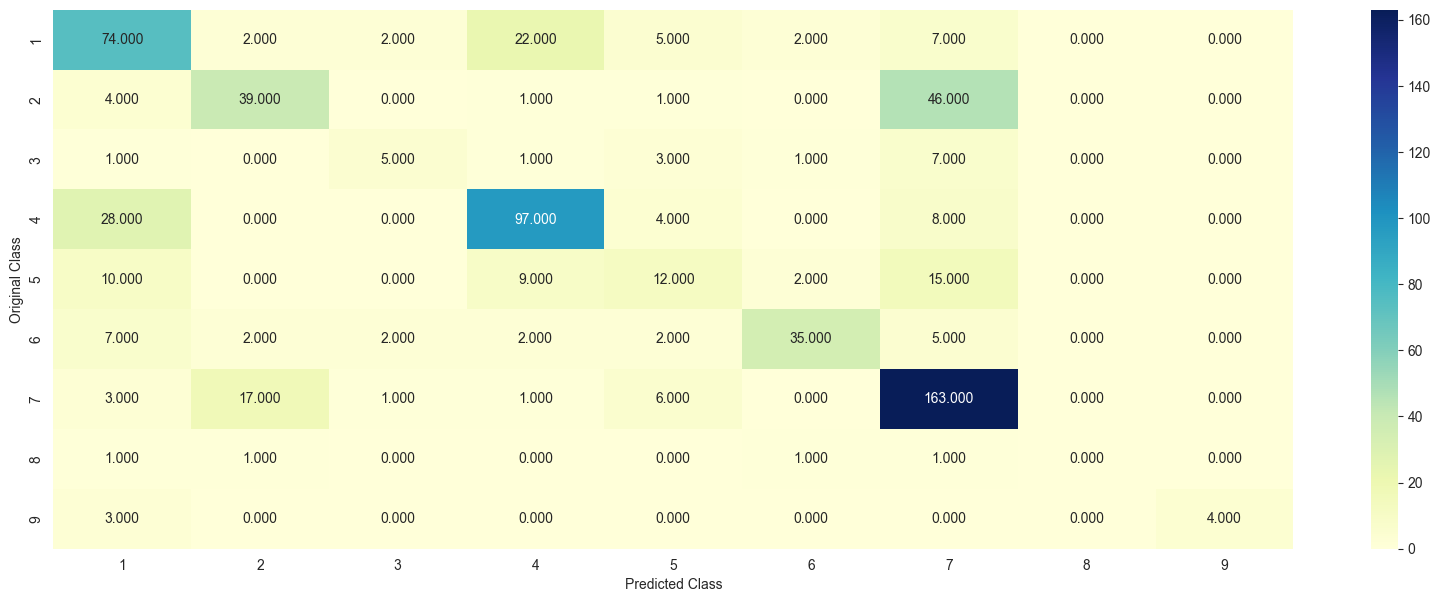

-------------------- Precision matrix (Columm Sum=1) --------------------


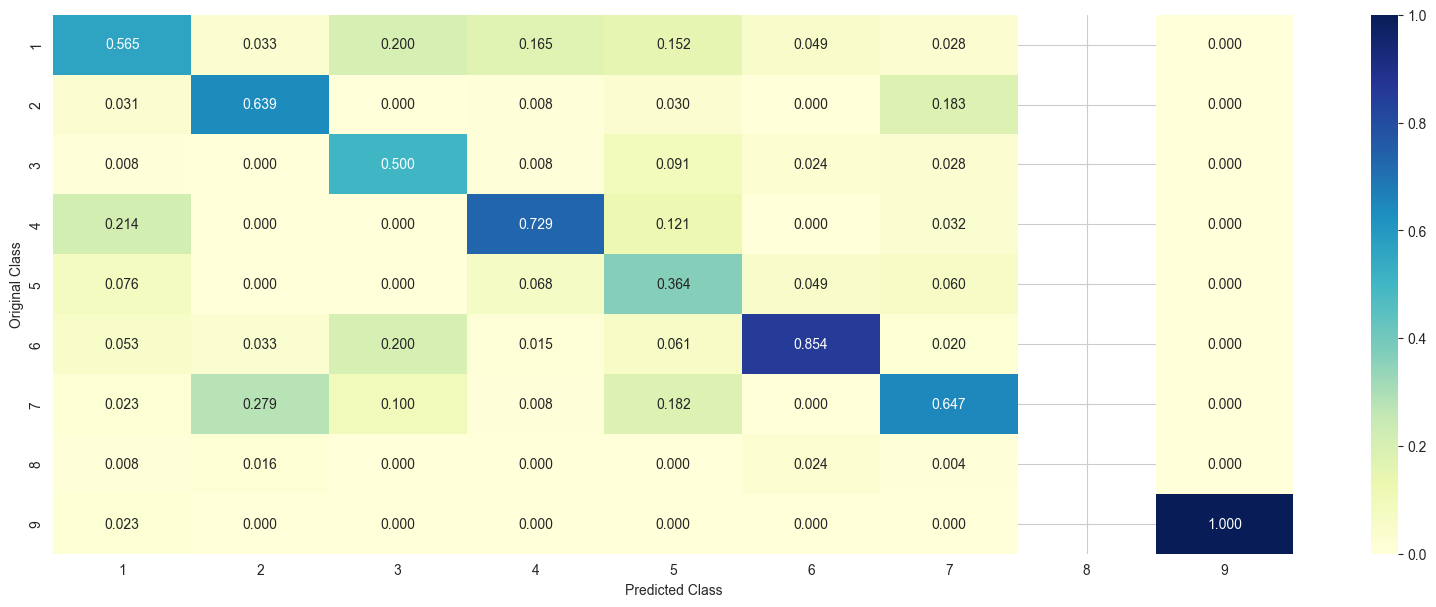

-------------------- Recall matrix (Row sum=1) --------------------


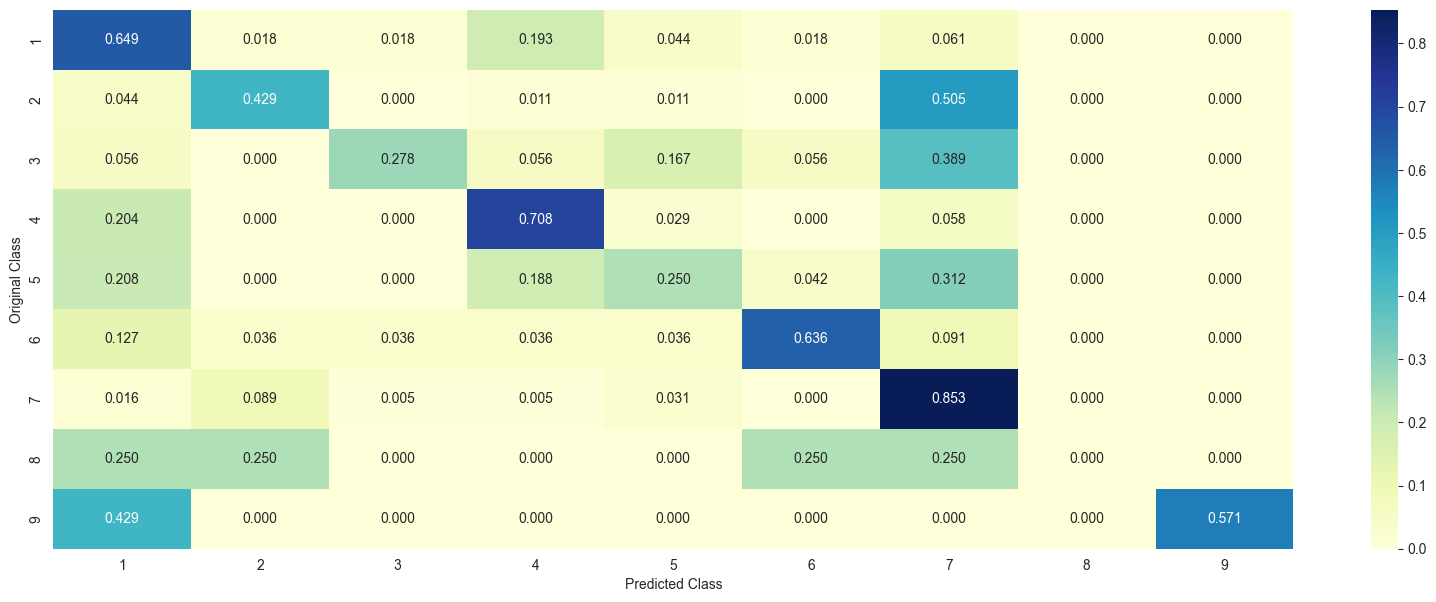

In [74]:
plot_confusion_matrix(test_y, calib_clf_LR.predict(test_x))

# Linear SVM

For alpha value of 1e-05 CV log loss = 1.431020345942337
For alpha value of 0.0001 CV log loss = 1.4322095464340543
For alpha value of 0.001 CV log loss = 1.4321935216676882
For alpha value of 0.01 CV log loss = 1.4480138333381831
For alpha value of 0.1 CV log loss = 1.404596544996926
For alpha value of 1 CV log loss = 1.2579322872933247
For alpha value of 10 CV log loss = 1.2017471609275832
For alpha value of 100 CV log loss = 1.3155994122557715
For alpha value of 1000 CV log loss = 1.496091769475515
For alpha value of 10000 CV log loss = 1.5565829188619542


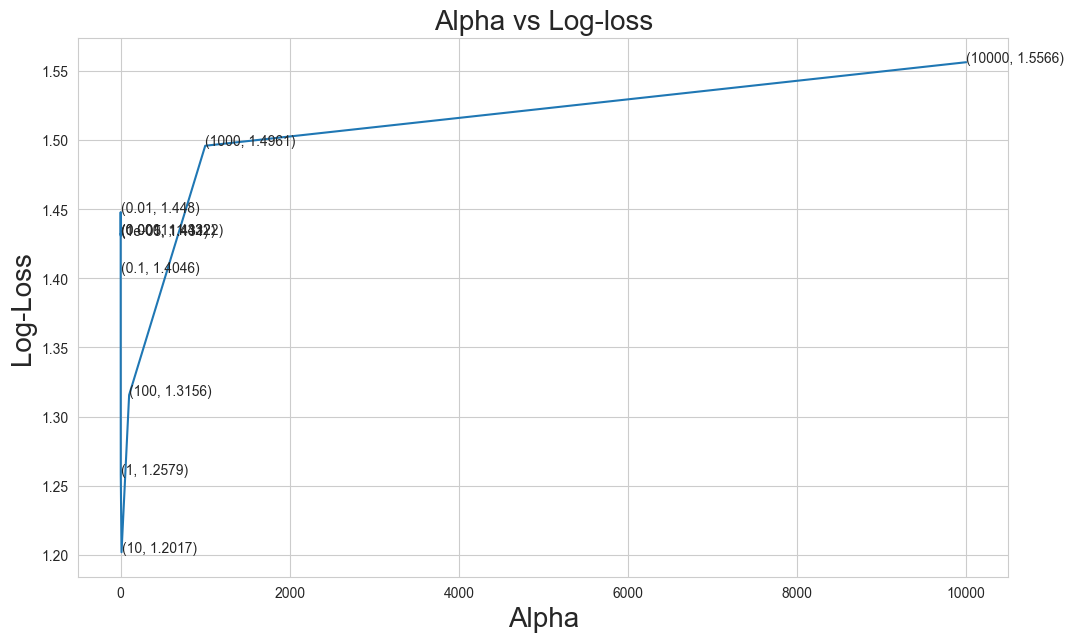

In [75]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i, class_weight = "balanced")
    clf.fit(train_x, train_y)
    calib_clf_SVM = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf_SVM.fit(train_x, train_y)
    predicted_y = calib_clf_SVM.predict_proba(cv_x)
    cv_log_loss.append(log_loss(cv_y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [76]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "hinge", alpha = best_alpha, class_weight = "balanced")
clf.fit(train_x, train_y)
calib_clf_SVM = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_SVM.fit(train_x, train_y)

predict_train = calib_clf_SVM.predict_proba(train_x)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_SVM.predict_proba(cv_x)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_SVM.predict_proba(test_x)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.7239377081441282
For values of best alpha =  10 the CV log loss =: 1.2082013752972662
For values of best alpha =  10 the test log loss =: 1.1700378705458794


# Feature Importance

In [77]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_SVM.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_SVM.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 37.78%
Percentage of mis-classified for Test points = 34.14%


In [78]:
import pandas as pd

# Create an empty DataFrame with the desired columns
loss_table = pd.DataFrame(columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

# Define the new data as a DataFrame
new_data = pd.DataFrame([["Linear SVM", 0.706, 1.1807, 1.2474, "37.59%", "39.85%", "Goodfit"]], columns=["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

# Concatenate the new data with the existing DataFrame
loss_table = pd.concat([loss_table, new_data], ignore_index=True)

# Print the DataFrame
print(loss_table)


        Model  Train Log-loss  CV Log-loss  Test Log-loss Mis-Classified CV  \
0  Linear SVM           0.706       1.1807         1.2474            37.59%   

  Mis-Classified Test  Remarks  
0              39.85%  Goodfit  


-------------------- Confusion matrix --------------------


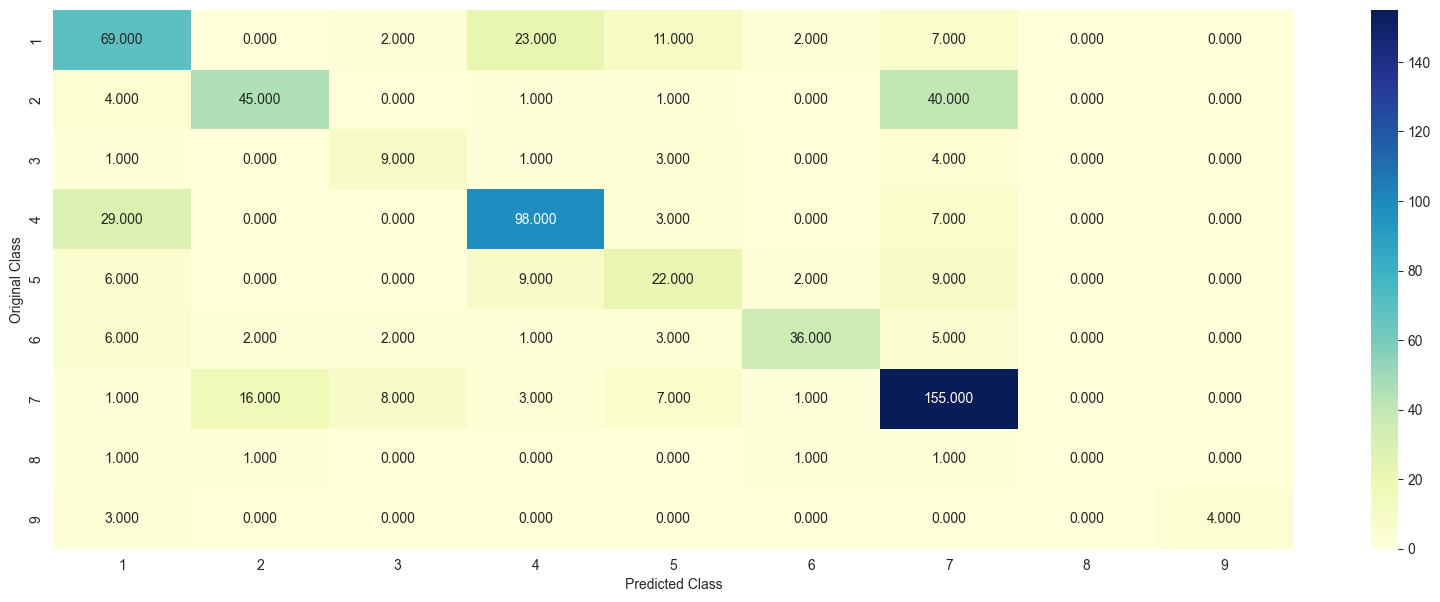

-------------------- Precision matrix (Columm Sum=1) --------------------


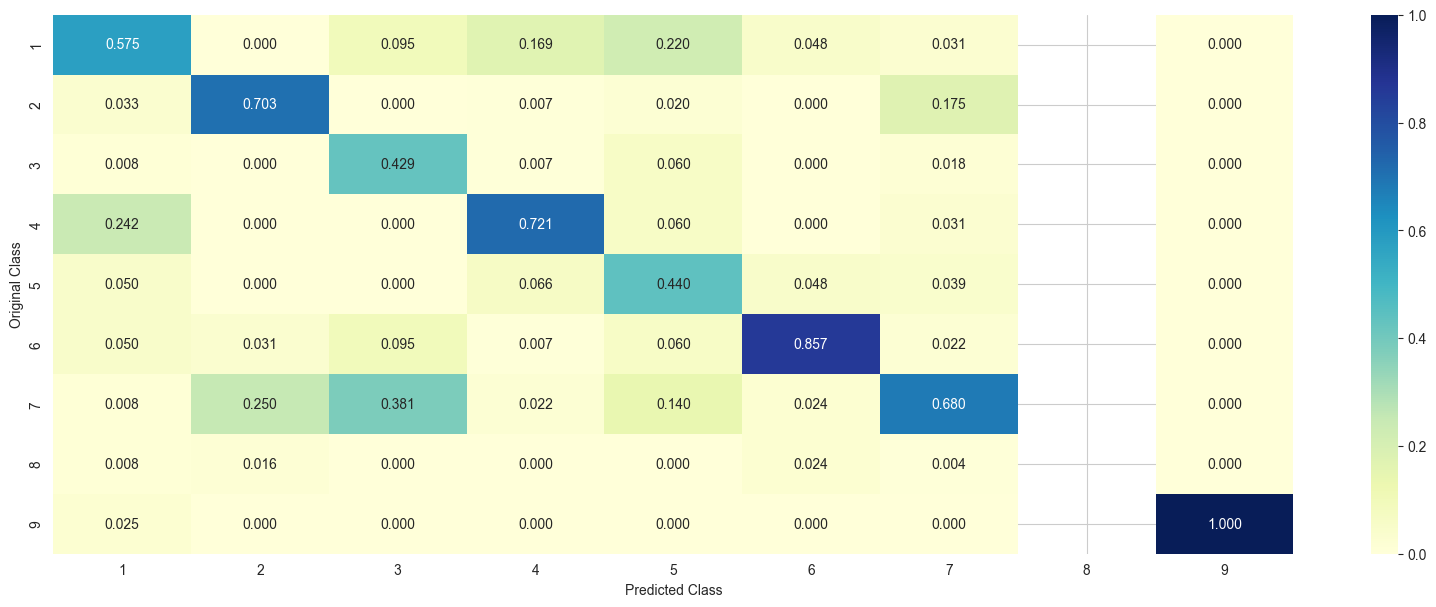

-------------------- Recall matrix (Row sum=1) --------------------


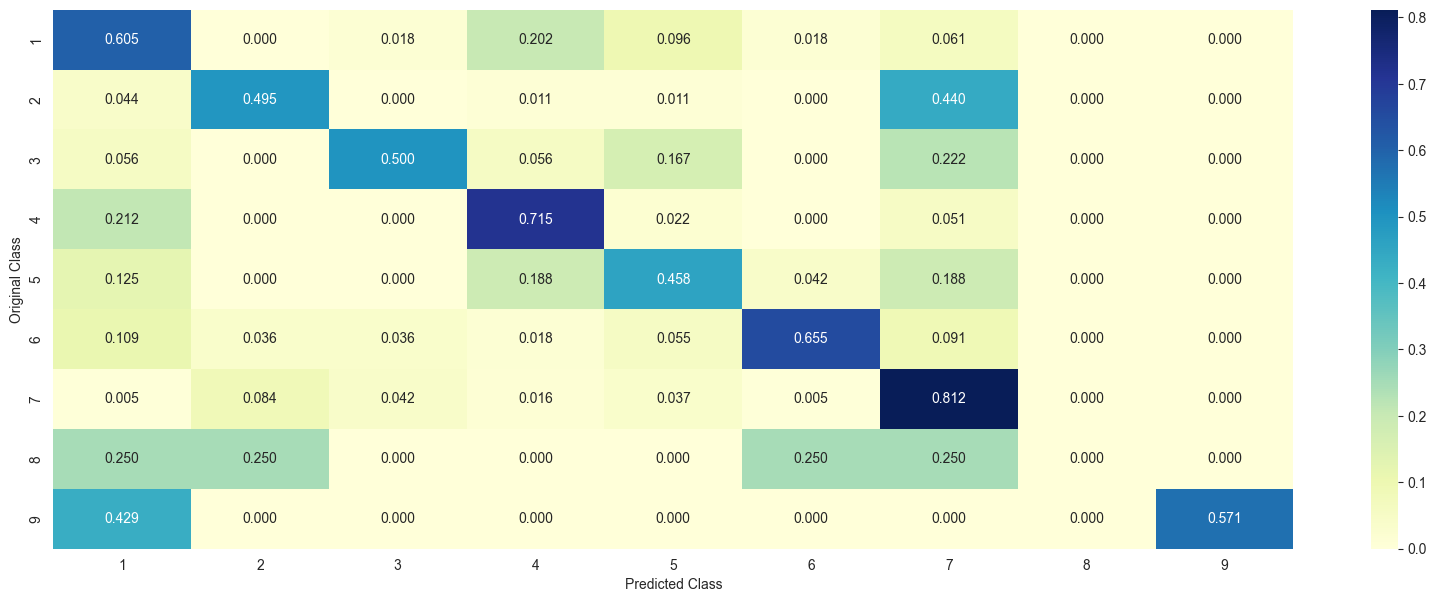

In [79]:
plot_confusion_matrix(test_y, calib_clf_SVM.predict(test_x))

#  SVM Summary

In [80]:
loss_table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,Linear SVM,0.706,1.1807,1.2474,37.59%,39.85%,Goodfit
